# Causal Inference Introduction
 
**Ruchi Bhavsar, Darshil Patel, and Andrew Lemke**
 
**Causal Machine Learning Summer 2022**
 

In [1]:
import graphviz
import dowhy
from dowhy import CausalModel
import pandas as pd

 
# What is causal inference and what does it do?
 
Describing the goal of causal inference in relation to traditional (predictive) modeling highlights the key difference. _In most data science modeling, prediction is the goal_--given a sample X, predict some output y. Usually the predictor is some machine learning (ML) model. The data scientist has many samples of X and their corresponding y's, and whether the model be some regression or classification, the data scientist uses these samples and some ML learning scheme to build a model that gives an output for some X where this output matches the true output for many observed samples. The predictor could even be entirely black boxed and still satisfy many needs.
 
Causal models seek to explain _how the data was generated_--we are making a generative model not a predictive model. With causal inference, we are modeling the process that creates the data, explaining how a certain observation (X, y) came to be. Causal reasoning is more natural for humans; we make our predictions based on known causes and effects. Causal models have the ability to generalize better and can give insight to why a prediction is made.
 
 
 
## DAGs and causal inference
 
Directed acyclic graphs (DAGs) can be used as a representation of this generating process. Nodes hold the variables in the system, and edges define the causal relationships.
 
<img src="https://drive.google.com/uc?export=view&id=1svpZNKJoj7ERdxK3gIfkPS8Qy2n4vu_b"  width="400">
 
Here is an example of a DAG that might be constructed for a company looking to model their advertising on a popular video streaming site.
 
The DAG can be used to generate samples. Along with the actual output of the model, the DAG also gives us the values of all the nodes that cause the output. The DAG itself gives us insights to why things happen. When we model causality with a DAG, we naturally get conditional independence between variables in the system. In the example above, we can extract information like P(sale | Ad Type) or p(Sale|Times seen). More importantly, we can simulate interventions, allowing us to see from the data how showing ads to people multiple times influences our (statistical) expectation of sales. A predictive model does not have this capability.
 
Where do you get these probabilities? In most cases, they are learned from data. This process can occur from some dataset that has attributes for all the nodes. We are not limited to just this method however. If we know from industry that the probability that a website visitor has a 0.019 chance of digesting the entirety of an arbitrary advertisement, then we can use this in our DAG. We can also incorporate known knowledge in other ways. If we set up our advertisements in the above example such that each advertisement has a different promotional level, then we can set those nodes accordingly.
 
 
## Correlation and Causality
 
You might be wondering, "If we just learned these causal relationships from observational data, wouldn't we have used correlation to derive causation, going against the established fact that "correlation does not imply causation""? In a way we are, but it is not problematic. 
 
The first reason is that "correlation does not imply causation" isn't the whole story. Richenbach's common cause principle holds that if we observe that two things that are correlated, one either causes the other or they share some common cause. When we look at observational data, domain knowledge (or just reason) allows us to narrow down this further. For example, if we see a correlation between bank customers who spend high amounts of time on hold and bank customers who then leave the bank, we can easily reason that customers leaving the bank does not cause their high weight times in the past.
 
The common cause bit is a little more tricky. Here, we must rely on domain knowledge to answer the question, "does this study adequately account for possible common causes?" If we think it does, then we can proceed to draw causal conclusions from our model.
 
 
The second reason is that this is the best alternative. If the company advertising on videos hired pure statisticians, they would receive tables of correlations with significance levels and carefully crafted language that avoids calling things "causes." For example, "we see a high degree of association between promotional discount level and clicking on advertisement." The company would then use the statisticians' report to make business decisions as if they were causes, and increase their promotional level to draw more customers. What causal modeling offers is a wrong model, but a useful one. The 5 non-outcome nodes in the above example are far from what is needed to capture all the decision making processes of each person exposed to an ad. The point of modeling is not to  account for every factor to make it correct. Modeling is about usefulness, and in situations where one cannot perform a controlled A/B experiment (the gold standard of causality), a causal model is often the best choice.
 
 
## Clearing up some vocabulary
 
A **generative model** enumerates the joint probability distribution of variables in the data generating process. It is named "generative" because once we have the joint probability, we can generate new samples.
 
A **discriminative model** predicts some output variable(s) from the data. This is also called a predictive model. Examples would include a neural net.
 
A **probabilistic model** is a model that includes probabilities in its output. This could be giving a probability distribution for output rather than a single point or class. Logistic regression is a probabilistic model while SVM is not as it just outputs the class.
 
A **Bayesian model** is a probabilistic model that handles uncertainty in not just outputs but internal elements as well, including the weights themselves.
 
 
# The four steps of causal inference
 
The four steps of causal inference are:
1. Model
2. Identify
3. Estimate
4. Refute
 
We will first go over the four steps, then show some code examples in `DoWhy` following these steps.
 
 
## 1. The Model
 
The choice of model is chief in the causal inference process. The model must account for the necessary variables to represent the true causal relationship, but also not become bloated by unnecessary variables that do not impact our causal query. One simple rule is: for any set of 2 or more variables in our graph, we cannot have a common cause of those variables not be included in the graph.
 
 
<img src="https://drive.google.com/uc?export=view&id=1Fdz_O5BusckBzryvLQ2Nn6TR-cykgO4A"  width="200">
 
<img src="https://drive.google.com/uc?export=view&id=1TZu6xcFLDh9uv6dx3RyX11LS-a6-HtAq"  width="200">
 
 
 
In the first example our model includes the nodes in blue, but not node Z. We need to account for node Z, because without it, we do not acknowledge the dependency between X1 and X2 as they share a common cause. In other words, our model (in blue) implies independence between X1 and X2, but in truth (blue and gray nodes), there is no independence as X1 and X2 are d-connected.
 
In the second example, we are safe to not include Z. Z does not d-connect X1 and X2.
 
 
### Types of nodes
 
Nodes can be classified based on their position in the graph. These classifications will be useful in the next step, identify. In the below example graph, we are trying to determine the causal effect of X on Y. We will explain each type of node in relation to this graph (ie X will be the treatment, Y will be the outcome). We wish to get $P(Y=y | do(X=x))$
 
<img src="https://drive.google.com/uc?export=view&id=1guMGqxl8jvs9BrIBso67q_hLWGuG50xf"  width="600">
 
* **Common Causes** - *Z1 above* These nodes have causal influence on both the treatment and the outcome. These nodes are also called confounders, as if we observe some correlation between X and Y, we cannot know if this is due to the effect of X on Y or due to association through Z1. Nodes like Z1 act as a "backdoor" of causal influence.
 
* **Mediators** - *M above* While Z1 might be the backdoor, M is the frontdoor. Even if 
 
* **Instrument Variables (IVs)** - *Z2, Z3 above* These variables are causes for the treatment but not for the outcome on any path of causality not through X. In other words, their only causal path to Y is through X.  
 
 
 
## **2. Identify**
 
 
### The backdoor adjustment
The backdoor method works if we know all the common causes of X and Y. If we know Z1 or all the nodes like it, then we can use the backdoor estimate.
 
 
### The frontdoor adjustment
 
In the same example, M acts as the mediator for causality through X. If we have a node like this, then we can use the frontdoor method. The reason why this works is because M captures the causal effect going from X to Y *not going through the backdoor*. Having an observed node like M allows us to calculate this effect.
 
 
### Instrumental Variables 
 
Instrumental variable estimation is possible when IVs exist for X. Here is a brief explanation of why we can calculate the effect with mediators. If the backdoor (Z1) and the instruments (Z2, Z3) are independent of each other, then an estimator for Y based on the instruments would be equal to an estimator for Y based on the instruments and the back door. How do we know they are independent? They are not connected in the DAG. 
 
If we regress on the instruments, what we get is the effect on the instruments and X on Y. If we create another estimate of the effect of the IVs on X, which is not difficult as we are just looking at the simple causal relationship of Z2 -> X and Z3 -> X, then we can divide the estimated effect of instruments and X on y by the effect of the instruments, then we can get just the effect of X on Y. 
 
The largest benefit of this method is that we do not even need to know the backdoor values. If we know there is a common cause, but we do not have data for it, we can still use the IVs to get the effect of X on Y.
 
### **Example**

The following DAG has all three ways of identification. An example DoWhy Model is created from the DAG. DoWhy automatically solves identification, and its output confirms that each way is possible.

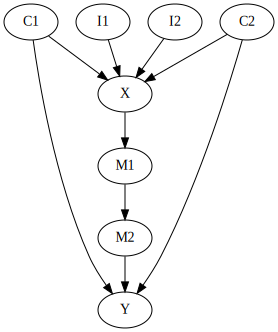

In [2]:
identity_example_dag = graphviz.Digraph('DAG')

identity_example_dag.node('Y')
identity_example_dag.node('X')
identity_example_dag.node('M1')
identity_example_dag.node('M2')
identity_example_dag.node('C1')
identity_example_dag.node('C2')
identity_example_dag.node('I1')
identity_example_dag.node('I2')


identity_example_dag.edges([('X', 'M1'),
           ('M1', 'M2'), 
           ('M2', 'Y'), 
           ('C1', 'X'),
           ('C2', 'X'),
           ('C1', 'Y'), 
           ('C2', 'Y'),
           ('I1', 'X'), 
           ('I2', 'X'),
])
identity_example_dag

In [3]:
identity_example_dag_for_model = identity_example_dag.source.replace(' DAG', '').replace('\n', ';').replace('\t', '').replace('{;Y', '{Y')

In [4]:
model_example = CausalModel(
    data=pd.DataFrame(
        {
            'C1': [],
            'C2': [],
            'X': [],
            'Y': [],
            'M1': [],
            'M2': [],
            'I1': [],
            'I2': [],
    }),
    treatment='X',
    outcome='Y',
    graph=identity_example_dag_for_model
)

In [5]:
identify_example = model_example.identify_effect(proceed_when_unidentifiable=True)
print(identify_example)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d              
────(E[Y|C2,C1])
d[X]            
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,C2,C1,U) = P(Y|X,C2,C1)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                             -1⎤
 ⎢    d        ⎛    d         ⎞  ⎥
E⎢─────────(Y)⋅⎜─────────([X])⎟  ⎥
 ⎣d[I₂  I₁]    ⎝d[I₂  I₁]     ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→Y then ¬(U →→{I2,I1})
Estimand assumption 2, Exclusion: If we remove {I2,I1}→{X}, then ¬({I2,I1}→Y)

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡  d       d        ⎤
E⎢─────(Y)⋅────([M₂])⎥
 ⎣d[M₂]    d[X]      ⎦
Estimand assumption 1, Full-mediation: M2 intercepts (blocks) all directed paths from X to Y.
Estimand assumption 2, First-stage-unconfoundedness: If U→{X} and U→{M2} then P(M2|X,U) = P(M2|X)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{M2} and U→Y then P(Y|M2, X, U) = P(

## **3. Estimate**
 
There are a variety of ways to estimate the causal effect in `DoWhy`. We will explain the broad categories.
 
 
### Linear model
 
The linear model fits on the common causes and the treatment predicting on Y. It then extracts the causal effect from this model. This approach assume linear relationships between causes and Y.
 
### Propensity scores
 
A propensity score seeks to be a single value replacement that explains the effect of all the common causes. This single entity acts as a proxy for the common causes and makes calculating the backdoor more feasible. If there were many common causes (or high dimensional common causes), then the straightforward method of calculating the backdoor may not be practical. There are a number of individual strategies that fall under this broad category.
 
 
### IV based strategies
 
One is called regression discontinuity, where the model searches for some partition that separates the data between the two treatment values. It then uses values close to the threshold to estimate because values close to the partition  should have similar confounder values.
 
### Double ML
 
This method uses ML to predict the outcome from the common causes and predict the treatment from the common causes. It then combines these models to estimate the effect of the treatment on the outcome. Its strength is that these models can work well with many common causes that may be a challenge for backdoor estimation, but easy to make a model from. For example, if there are 50 common causes, then the integration over all of them for the backdoor strategy is just not feasible, but making an ML model with 50 features is not challenging. The flexibility in model choice is another benefit.
 
 
## **4. Refute**
 
Assumptions are made in modeling and estimating the causal effect. We would like some way to challenge our model's view of the causal effect.
 
* **random common cause** This strategy generates a random common cause, for example one that may be unobserved or unmodeled. As a random common cause should have no effect on our estimate, adding it in should not change the estimated effect. [Docs](https://py-why.github.io/dowhy/v0.8/dowhy.causal_refuters.html?highlight=random_common_cause#module-dowhy.causal_refuters.random_common_cause)
 
* **Placebo** This strategy replaces the treatment with a randomly generated variable. If the treatment variable is random, we should expect no detected causality on the outcome. Here, the model is good when the refutation effect is 0. [Docs](https://py-why.github.io/dowhy/v0.8/dowhy.causal_refuters.html?highlight=placebo#module-dowhy.causal_refuters.placebo_treatment_refuter)
 
 